# Обучение нейронных сетей
Задание курса **Coursera ML with Andrew Ng**. Неделя 5.
Обучен ие нейросетей с помощью алгоритма `backpropagation`.
Минимизация функции будет осуществляться градиентным спуском с проверкой градиентов.

На прошлой неделе мы осуществили `feedforward propagation` для предсказания чисел, задача этой недели остается прежней, однако механизм усложняется, теперь мы самостоятельно будем обучать нейросеть. Требуется полный проход в обе стороны. 
## Подготовка датасетов

In [2]:
from scipy.io import loadmat
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import utils

In [28]:
%cd ~/Documents/ML/machine-learning-ex4/ex4/

mat = loadmat('ex4data1.mat')
X = np.array(mat['X'])
Y = np.array(mat['y'])
m,n = X.shape

mat_weights = loadmat('ex4weights.mat')
Theta1 = np.array(mat_weights['Theta1'])
Theta2 = np.array(mat_weights['Theta2'])

weights = np.concatenate((Theta1.flatten(),Theta2.flatten()))

pd.DataFrame(X).head()

/Users/love/Documents/ML/machine-learning-ex4/ex4


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Как и в прошлом упражнении, посмотрим на примеры имеющихся картинок:

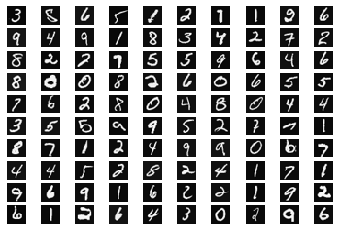

In [17]:
def draw_images(X, amount = 100):
    
    for i in range(1,amount +1):
        index = np.random.randint(0,4999)
        num = X[index,:].reshape(20,20).T
        
        ax = plt.subplot(10,10,i)
        ax.imshow(num, cmap="gray")
        plt.axis('off')
    
    plt.show()
draw_images(X)

## Стоимостная функция нейронной сети
Без регуляризации и при $ L = 1 $ функция выглядит так:
$$ J(\theta) = \frac{1}{m} \sum \limits _{i=1} ^{m} \sum \limits _{k=1} ^{K} [ -y_k^{(i)} \log((h_\theta(x^{(i)}))_k) - (1 - y_k^{(i)}) \log(1 - (h_\theta(x^{(i)}))_k)] $$
При этом $ h_\theta(x^{(i)})_k = a^{(3)}_k $ — активация исходного нейрона определенного числа.

Мы объеденим веса в один вектор, для воссоздания матриц $ \Theta $ потребуются параметры:
$l_1$ — количество нейронов на входном слое, $l_2$ — количество нейронов в скрытом слое, $K$ — количество выходных нейронов.
В нашем случае $ \Theta^{(1)} \in \vec{\theta}, \Theta^{(2)} \in \vec{\theta} $, воссоздание весов происходит следующим образом:
$$ \Theta^{(1)} = \vec{\theta}[1:l_2 \times (l_1 + 1)] \in \mathbb{R}^{l_2 \times (l_1 + 1)} $$
$$ \Theta^{(2)} = \vec{\theta}[l_2 \times (l_1 + 1) + 1:] \in \mathbb{R}^{K \times (l_2 + 1)}$$

Для нахождения стоимостной функции мы используем `feedforward propagation`, полностью прогоняя нейросеть в одном направлении

### Касательно векторизации и размерностей
Используя `one hot encoding` мы получим матрицу $ Y \in \mathbb{R}^{m \times k}$ и матрицу активаций выходных нейронов $ H \in \mathbb{R}^{m \times k} $, для получения аналога двойному суммированию в векторной форме мы будем использовать не матричное умножение, но поэлементное. В матричном виде функция будет выглядеть так:
$$ J(\theta) = \frac{1}{m} \sum -Y \cdot \ln(H) - (1-Y) \cdot \ln(1-H) $$


### Регуляризация
Стоимостная функция для логистической регрессии в нейросетяж выглядит так:
$$ J(\theta) = \frac{1}{m} \sum \limits _{i=1} ^{m} \sum \limits _{k=1} ^{K} [-y_k^{(i)} \log(h_\theta(x^{(i)})_k) - (1 - y_k^{(i)}) \log(1 - h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m} [\sum \limits _{j=1} ^{l_2} \sum \limits _{k=1} ^{l_1} (\Theta_{j,k}^{(1)})^2 + \sum \limits _{j=1} ^{K} \sum \limits _{k=1} ^{l_2} (\Theta_{j,k}^{(2)})^2] $$

In [18]:
def sigmoid(z):
    return 1/(1 + np.exp(-1 * z))

def hypothesis(X, theta):
    z = theta @ X.T
    return sigmoid(z).T

def with_bias(X):
    m,n = X.shape
    return np.concatenate((np.ones((m,1)),X),1)

def one_hot_encoding(y, k = 10):
    m,n = y.shape
    
    Y = np.zeros((m,k))
    for i in range(len(y.reshape(m))):
        Y[i,y[i] - 1] = 1
    return Y

In [19]:
# @param weights — all flatten weights
# @param input_size — is a length of a hidden layer
# @param hidden_size is a shape of a hidden layer
# @param num_labels is a OHE shape, amount of classified items
def cost(weights, input_size, hidden_size, num_labels, X,y,reg = None):
    start = datetime.now()
    
    Theta1 = weights[0:hidden_size * (input_size +1)].reshape(hidden_size, input_size + 1)
    Theta2 = weights[hidden_size * (input_size +1):].reshape(num_labels, hidden_size + 1)
    
    m,n = X.shape
    
    a1 = with_bias(X)
    z2 = Theta1 @ a1.T
    a2 = with_bias(sigmoid(z2).T)
    z3 = Theta2 @ a2.T
    a3 = sigmoid(z3).T
    H = a3
    
    Y = one_hot_encoding(y, num_labels)
    
    d3 = a3 - Y
    print(Theta2.T.shape, d3.shape, z2.shape)
    d2 = Theta2.T @ d3.T * with_bias(sigmoidGrad(z2).T).T
    
    modifier = 0
    if reg != None:
        modifier = reg / (2 * m) * (np.sum((Theta1[:,1:])**2) + np.sum((Theta2[:,1:])**2))
    
    J = np.sum(-Y * np.log(H) - (1 - Y) * np.log(1-H))/m + modifier
    
    end = datetime.now() - start
    print("Cost calculation took", end)
    return J

In [20]:
J = cost(weights, 400, 25, 10, X,Y,3)
print("J is %.3f" %J)

(26, 10) (5000, 10) (25, 5000)
Cost calculation took 0:00:00.039928
J is 0.576


## Backpropagation
### Производная от логистической функции
Теперь для вычисления производных пройдем backpropagation. В первую очередь найдем производную логистической функции:
$$ g'(z) = \frac{d}{dz}g(z) = g(z)(1 - g(z)) $$

### Случайная инициализация
Для тренировки нейросетей необходимо использовать случайно полученные веса для избежания нейронов близнецов. Хорошим примером генерации будет задание матрицы $ \Theta^{(l)} \in [-\epsilon_{init}; \epsilon_{init}] $. В данном варианте мы используем $ \epsilon_{init} = 0.12 $. Это число выбирается исходя из числа нейронов: $ \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}} $, где $ L_{in} $ — число $ s_l $, $ L_{out} $ — число $ s_{l+1} $: количества нейронов относительно $ \Theta^{(l)} $

### Ошибки нейронов
Теперь мы производим `feedforward propagation`, чтобы вычислить активации, и по ним найти ошибки нейронов. Для выходного слоя:
$$ \delta_k^{(3)} = (a_k^{(3)} - y_k), \delta^{(3)} \in \mathbb{R}Y \Longleftrightarrow \mathbb{R}^{m \times K} $$ 

Для скрытого слоя:
$$ \delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} \cdot g'(z^{(2)}), \delta^{(2)} \in \mathbb{R}A_2 \Longleftrightarrow \mathbb{R}^{(l_2 + 1) \times m} $$

Отсюда мы можем найти градиенты:
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l + 1)} (a^{(l)T}), \Delta^{(2)} \in \mathbb{R}^{(l_2) \times K}, \Delta^{(1)} \in \mathbb{R}^{l_2 \times l_1 } $$
При этом мы пропустим $\delta^{(l + 1)}_0 $.

Наконец, можем посчитать производную по весам:
$$ \frac{\partial}{\partial\Theta_{i,j}^{(l)}} J(\Theta) = D_{i,j}^{(l)} = \frac{1}{m} \Delta^{(l)}_{i,j} $$

In [11]:
def sigmoidGrad(z):
    return sigmoid(z) * (1 - sigmoid(z))

def random_weights(l_in, l_out):
    epsilon_init = 0.12;
    return np.random.rand(l_out, l_in) * 2 * epsilon_init - epsilon_init;
    

In [12]:
def backprop(weights, input_size, hidden_size, num_labels, X,y,reg = None):
    start = datetime.now()
    
    Theta1 = weights[0:hidden_size * (input_size +1)].reshape(hidden_size, input_size + 1)
    Theta2 = weights[hidden_size * (input_size +1):].reshape(num_labels, hidden_size + 1)
    
    m,n = X.shape
    
    a1 = with_bias(X)
    
    print(a1.shape, Theta1.shape)
    z2 = Theta1 @ a1.T
    a2 = sigmoid(z2).T
    z3 = Theta2 @ with_bias(a2).T
    a3 = sigmoid(z3).T
    H = a3
    
    Y = one_hot_encoding(y, num_labels)
    
    
    d3 = a3 - Y
    print("HERE", Theta2.shape,d3.shape, z2.shape)
    d2 = (Theta2.T @ d3.T) * with_bias(sigmoidGrad(z2).T).T
    
    dl2 = (d3.T @ a2).T
    dl1 = d2[1:,:] @ a1
    
    D1 = dl1 / m
    D2 = dl2 / m
    
    print(dl2.shape,dl1.shape)
    
    print(Theta2.shape, d3.shape,d2.shape,dl2.shape, a2.shape, a1.shape)
    
    
    modifier = 0
    if reg != None:
        modifier = reg / (2 * m) * (np.sum((Theta1[:,1:])**2) + np.sum((Theta2[:,1:])**2))
    
    J = np.sum(-Y * np.log(H) - (1 - Y) * np.log(1-H))/m + modifier
    
    end = datetime.now() - start
    print("Cost calculation took", end)
    return J  

In [13]:
J = backprop(weights, 400, 25, 10, X,Y,3)
print("J is %.3f" %J)

(5000, 401) (25, 401)
HERE (10, 26) (5000, 10) (25, 5000)
(25, 10) (25, 401)
(10, 26) (5000, 10) (26, 5000) (25, 10) (5000, 25) (5000, 401)
Cost calculation took 0:00:00.061716
J is 0.576


## Проверка градиента
Для проверки градиента на вычисление и баги мы можем написать простой алгоритм апроксимации, сравнение с которым предоставит нам большую уверенность в расчетах.


In [23]:
def grad_check():
    l1 = 3
    l2 = 5
    l3 = 3
    m = 5 
    
    Theta1 = random_weights(l2,l1 +1)
    Theta2 = random_weights(l3,l2 +1)
    
    print(Theta1.shape,Theta2.shape)
    
    X = random_weights(m, l1-1).T # generated X via weights doge
    Y = np.mod(np.arange(1,m+1), m).T.reshape(5,1)
    
    print(X.shape, Y.shape)
    params = np.concatenate((Theta1.flatten(),Theta2.flatten()),0)
    
    J_log = backprop(params, l1,l2,l3,X,Y) 
    
    return J_log

In [24]:
th = grad_check()
pd.DataFrame(th).head()

(4, 5) (6, 3)
(5, 2) (5, 1)
(5, 3) (5, 4)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)